In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

### Getting Relevant Data

In [ ]:
query = """
SELECT table_id, row_count FROM `fccdsicapstone-218522.broadband.__TABLES__`
"""
tables = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

mask = (tables.table_id.str.contains('acs') &
        ~tables.table_id.str.contains('group') &
        ~tables.table_id.str.contains('level') &
        tables.row_count.between(190000, 220000))
tables[mask].sort_values('row_count', ascending=False)

In [2]:
query_new = """
WITH block_level AS (
  SELECT 
    SUBSTR(block.block_code, 0, 12) AS block_group
    , CASE WHEN fcc.block_code IS NULL THEN 0 ELSE 1 END AS int_avail
    , CASE WHEN fund.census_block IS NULL THEN 0
           WHEN fund.max_down = 4 AND fund.max_up = 1 THEN 2
           ELSE 1 END AS fund_provided
    , CASE WHEN fcc.block_code IS NOT NULL AND fund.census_block IS NULL THEN 0 ELSE 1 END AS avail_not_funded
    
  FROM broadband.census_block block
  LEFT JOIN (SELECT DISTINCT block_code, holding_company_name FROM broadband.fcc WHERE file_date = 201706 AND max_down > 4.0 AND max_up > 1.0) fcc
    ON block.block_code = fcc.block_code
  LEFT JOIN broadband.fcc_demography
    ON block.block_code = fcc_demography.block_code
  LEFT JOIN broadband.fund
    ON block.block_code = fund.census_block
  WHERE fcc_demography.population_2016 > 0 AND fcc_demography.housing_unit_2016 > 0 
),


block_group_level AS ( 
  SELECT 
    block_group
    , AVG(int_avail) AS int_avail_per
    , AVG(fund_provided) AS fund_provided_per
    
  FROM (SELECT * FROM block_level WHERE avail_not_funded = 1 AND fund_provided < 2)
  GROUP BY block_group
)

SELECT DISTINCT
  block_group_level.block_group
  , block_group_level.int_avail_per
  , block_group_level.fund_provided_per
  
  , SAFE_DIVIDE(data.road_length, data.land_area) AS road_density
  , data.elev_mean
  , data.elev_range
  , data.winter_temp AS winter_temperature
  , SAFE_DIVIDE(data.population, data.land_area) AS population_density
  , data.male_rate
  , data.median_income
  , data.median_age
  , data.white_rate
  , data.avg_years_of_edu
  , data.unemployment_rate
  , SAFE_DIVIDE(data.housing_units, data.land_area) AS housing_density
  , data.house_owner_rate
  , data.newly_moved_household_rate
  , data.newly_built_housing_rate
  , law.laws_against
  --, IFNULL(law.type, 'no_law') AS law_type
FROM block_group_level
LEFT JOIN broadband.tiger_acs_2016 AS data
  ON block_group_level.block_group = data.block_group
LEFT JOIN broadband.laws_against_municipal_broadband law
  ON SUBSTR(block_group_level.block_group, 0, 2) = law.state_code
"""
all_data_new = pd.read_gbq(query_new, project_id='fccdsicapstone-218522', dialect='standard')

#### Only No Internet Available Blocks and Funded Blocks are included in this data

In [3]:
all_data_new.shape

(72849, 19)

### Data Cleaning for New Data

In [4]:
# np.unique(all_data_new['verizon_provided_per'])

In [5]:
all_data_new.count() / all_data_new.shape[0] * 100
data_new = all_data_new.dropna()
print(data_new.shape)

mask = ((data_new.elev_range < data_new.elev_range.quantile(0.99)) &
        (data_new.road_density < data_new.road_density.quantile(0.98)) &
        (data_new.population_density < data_new.population_density.quantile(0.98)))

data_new = data_new[mask]

print(data_new.shape)

#convert the column of true/false to 1/0
data_new['laws_against'] = data_new['laws_against'].astype(int)

#data_new['verizon_provided_per'] = (data_new['verizon_provided_per'] > 0.5).astype(int)

(71174, 19)
(68050, 19)


In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Model for New

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

target_col = 'fund_provided_per'
X = data_new.drop(columns=['int_avail_per', 'block_group', target_col])
y = data_new[target_col]
y = (y > 0.5).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [8]:
y.value_counts()

0    49318
1    18732
Name: fund_provided_per, dtype: int64

### Balanced Model

In [9]:
#Random Forest Model

RFmodel_balanced = RandomForestClassifier(class_weight='balanced')
params = {
     'n_estimators': [200],
    'min_samples_split': [65, 70, 75, 80],
    'max_depth': [70, 75, 80, 85],
}
 
grid_search_balanced = GridSearchCV(estimator=RFmodel_balanced, param_grid=params, scoring='f1', cv=3, n_jobs=-1, verbose=True)
grid_search_balanced.fit(X_train, y_train)

print('Train score', grid_search_balanced.score(X_train, y_train))
print('Test score', grid_search_balanced.score(X_test, y_test))



Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  8.2min finished
/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:714: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train score 0.7256729345978838
Test score 0.6183138895003302


In [10]:
print (grid_search_balanced.best_params_)

coefficients = pd.DataFrame(list(zip(X.columns, grid_search_balanced.best_estimator_.feature_importances_))
                            , columns=['feature', 'gini_coef'])
coefficients_sort = coefficients.sort_values('gini_coef', ascending=False)

{'max_depth': 85, 'min_samples_split': 75, 'n_estimators': 200}


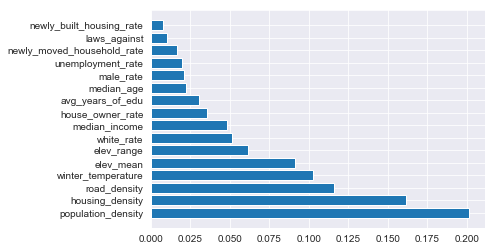

In [11]:
import seaborn as sns
#Set Seaborn Theme
sns.set_style('darkgrid')

plt.barh(coefficients_sort['feature'], coefficients_sort['gini_coef'])
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix
CM_balanced = confusion_matrix(y_test, grid_search_balanced.predict(X_test))

Confusion matrix, without normalization
[[7333 2578]
 [ 890 2809]]
Normalized confusion matrix
[[0.73988498 0.26011502]
 [0.24060557 0.75939443]]


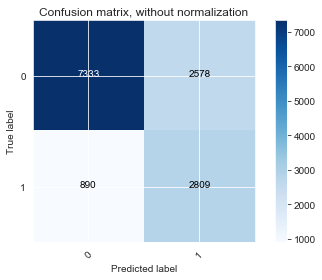

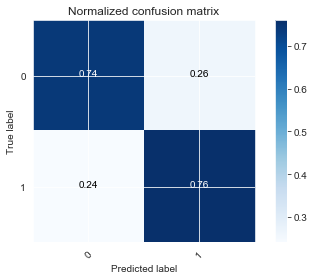

In [13]:
class_names = np.unique(y)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(CM_balanced, classes=class_names,
                      title='Confusion matrix, without normalization')

#Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(CM_balanced, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Predicting Block Groups that are likely to get funded in the future

In [14]:
no_enough_funded = data_new.iloc[np.where(y==0)].copy()

X_pred = no_enough_funded.drop(columns=['int_avail_per', 'block_group', target_col])
proba = grid_search_balanced.predict_proba(X_pred)
no_enough_funded['proba'] = proba[:, 1]

In [15]:
prediction = no_enough_funded.sort_values('proba', ascending=False)[['block_group', 'proba','fund_provided_per']]
prediction.to_csv('fund_prediction_result.csv', index = False)
prediction.head(10)

,block_group,proba,fund_provided_per
29065,551410111002,0.917524,0.000000
29201,550959609004,0.906654,0.000000
12362,551410107002,0.900626,0.107143
12728,551091206001,0.898963,0.230769
61317,271537901001,0.898830,0.000000
42210,260450207002,0.898017,0.000000
2306,270090201002,0.895381,0.423077
16491,271594802006,0.895008,0.434783
30586,550959605001,0.894851,0.000000
28411,550959610004,0.892530,0.000000
